In [1]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *

In [2]:
with open('./pickles/skl_quad.pkl', 'rb') as f:
    skl_quad = pickle.load(f)

In [3]:
w = skl_quad[0]['coef'][0].T
bias = skl_quad[0]['intercept'][0]
print(w.shape)
print(w.max(), np.unravel_index(np.argmax(w, axis=None), w.shape),\
      w.min(), np.unravel_index(np.argmin(w, axis=None), w.shape))

(450, 99)
4.153822214496827 (129, 76) -5.985928011055445 (257, 76)


In [4]:
gene = list(range(99))
for j in range(len(comp_ind)-1):
    for k in range(j+1, len(comp_ind)):
        gene.append([comp_ind[j], comp_ind[k]])
print(gene[129], gene[257])

[29, 56] [56, 95]


initial gene with quad var:  (30390, 450)
Target gene at t_+1:  (30390, 99)
Predicted gene at t_+1:  (30390, 99)
mean error:  0.1561452464110658


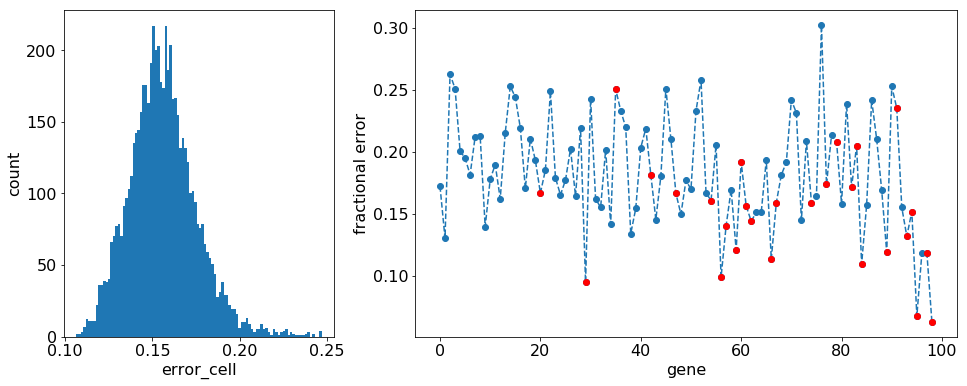

In [5]:
data_all = np.loadtxt('../data_complete.txt')
median = np.median(data_all, axis=0)
# data_all = data_all - median
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

quad_init = np.copy(all_init)
for i in range(len(comp_ind)-1):
    for j in range(i+1, len(comp_ind)):
        quad_init = np.hstack((quad_init, (all_init[:,comp_ind[i]]*all_init[:,comp_ind[j]])[:,None]))
print('initial gene with quad var: ', quad_init.shape)

y_actual = np.vstack([all_bin[i+1] for i in range(5)])
print('Target gene at t_+1: ', y_actual.shape)

y_pred = all_init + (bias + quad_init.dot(w))
print('Predicted gene at t_+1: ', y_pred.shape)

y_pred_nobias = all_init + quad_init.dot(w)

from matplotlib import gridspec

# error_nobias = (np.sum(np.abs(y_actual - y_pred_nobias)**2, axis=1)/np.sum(np.abs(y_actual)**2, axis=1))**(1/2)
# error_bin = np.vsplit(error_nobias[:,None], 5)
# error_cell = np.sum(error_bin, axis=0)/6
# error_gene_all_nobias = (np.sum(np.abs(y_actual - y_pred_nobias)**2, axis=0)/np.sum(np.abs(y_actual)**2, axis=0))**(1/2)

# fig = plt.figure(figsize=(16,6))
# gs = gridspec.GridSpec(1,2, width_ratios=[1,2])
# ax0 = plt.subplot(gs[0])
# ax0.hist(error_cell, bins=100)
# ax0.set_xlabel('error_cell')
# ax0.set_ylabel('count')

# ax1 = plt.subplot(gs[1])
# ax1.plot(range(99), error_gene_all_nobias, 'o--')
# ax1.plot(comp_ind, error_gene_all_nobias[comp_ind], 'ro')
# ax1.set_xlabel('gene')
# ax1.set_ylabel('fractional error')
# plt.show()

error = (np.sum(np.abs(y_actual - y_pred)**2, axis=1)/np.sum(np.abs(y_actual)**2, axis=1))**(1/2)
error_bin = np.vsplit(error[:,None], 5)
error_cell = np.sum(error_bin, axis=0)/6
error_gene_all = (np.sum(np.abs(y_actual - y_pred)**2, axis=0)/np.sum(np.abs(y_actual)**2, axis=0))**(1/2)
print('mean error: ', np.mean(error_cell))

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2, width_ratios=[1,2])
ax0 = plt.subplot(gs[0])
ax0.hist(error_cell, bins=100)
ax0.set_xlabel('error_cell')
ax0.set_ylabel('count')

ax1 = plt.subplot(gs[1])
ax1.plot(range(99), error_gene_all, 'o--')
ax1.plot(comp_ind, error_gene_all[comp_ind], 'ro')
# ax1.plot(range(99), error_gene_all_nobias, 'o--')
# ax1.plot(comp_ind, error_gene_all_nobias[comp_ind], 'ro')
ax1.set_xlabel('gene')
ax1.set_ylabel('fractional error')
plt.show()

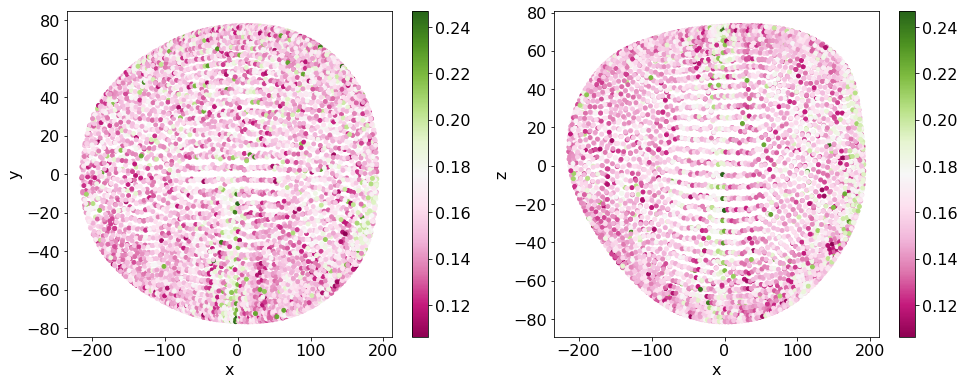

In [6]:
raw_data = np.loadtxt('../dmel_data.txt').T
xyz = raw_data[:,:3]
xlabels = ['x', 'y', 'z']

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
xy = ax.scatter(xyz[:,0], xyz[:,1], c=error_cell.flatten(), s=15, cmap=plt.cm.PiYG)
plt.colorbar(xy)
ax.set_xlabel(xlabels[0])
ax.set_ylabel(xlabels[1])
ax = fig.add_subplot(122)
xz = ax.scatter(xyz[:,0], xyz[:,2], c=error_cell.flatten(), s=15, cmap=plt.cm.PiYG)
plt.colorbar(xz)
ax.set_xlabel(xlabels[0])
ax.set_ylabel(xlabels[2])
plt.show()

In [7]:
init = np.copy(all_bin[0])

for iter in range(5):
    init_quad = np.copy(init)
    for i in range(len(comp_ind)-1):
        for j in range(i+1, len(comp_ind)):
            init_quad = np.hstack((init_quad, (init[:,comp_ind[i]]*init[:,comp_ind[j]])[:,None]))
    diff = init_quad.dot(w) + bias
    init += diff
y_pred = init
y_actual = all_bin[5]

print('Target gene at t_5: ', y_actual.shape)
print('Predicted gene at t_5: ', y_pred.shape)

Target gene at t_5:  (6078, 99)
Predicted gene at t_5:  (6078, 99)


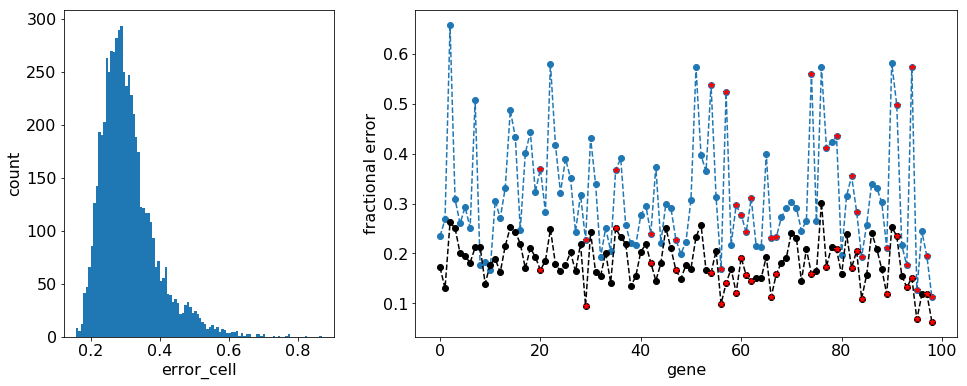

In [8]:
error_cell = (np.sum(np.abs(y_actual - y_pred)**2, axis=1)/np.sum(np.abs(y_actual)**2, axis=1))**(1/2)
error_gene = (np.sum(np.abs(y_actual - y_pred)**2, axis=0)/np.sum(np.abs(y_actual)**2, axis=0))**(1/2)

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2, width_ratios=[1,2])
ax0 = plt.subplot(gs[0])
ax0.hist(error_cell, bins=100)
ax0.set_xlabel('error_cell')
ax0.set_ylabel('count')

ax1 = plt.subplot(gs[1])
ax1.plot(range(99), error_gene, 'o--')
ax1.plot(comp_ind, error_gene[comp_ind], 'r*')
ax1.plot(range(99), error_gene_all, 'ko--')
ax1.plot(comp_ind, error_gene_all[comp_ind], 'r*')
ax1.set_xlabel('gene')
ax1.set_ylabel('fractional error')
plt.show()

In [9]:
def simulation(X, n_split=2, n_bin=2):
    X_split = np.vsplit(X, n_split)
    stacks = np.copy(X_split[0])
    for i in range(n_split-1):
        diff = X_split[i+1] - X_split[i]
        diff_inc = diff/n_bin
        for j in range(1, n_bin):
            stacks = np.dstack((stacks, X_split[i]+j*(diff_inc)))
        stacks = np.dstack((stacks, X_split[i+1]))
    return stacks

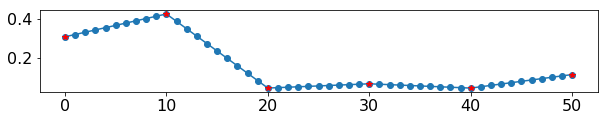

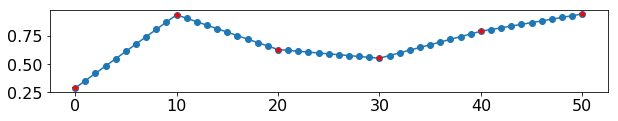

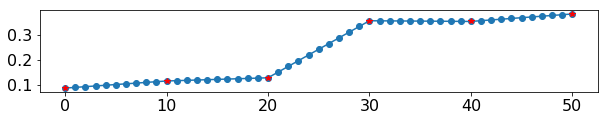

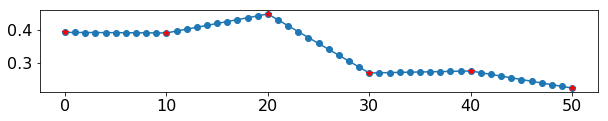

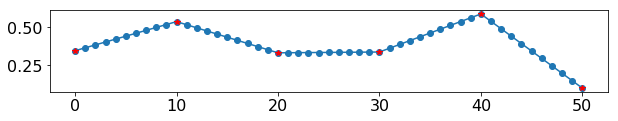

In [10]:
% matplotlib inline

n_bin = 10
stacks = simulation(data_all, n_split=6, n_bin=n_bin)

n = 5
cell = np.random.randint(6077, size=n)
gene = np.random.randint(98, size=n)
for c,g in zip(cell,gene):
    plt.figure(figsize=(10,1.5))
    plt.plot(range(5*n_bin+1), stacks[c,g,:],'o-')
    plt.plot(range(0,5*n_bin+1,n_bin), stacks[c,g,::n_bin],'r*')
    plt.show()

In [11]:
def sim_diff(X, w, bias):
    diff = np.empty([6078,99,0])
    r, c, d = X.shape
    for i in range(d):
        init = X[:,:,i]
#         print(init.shape)
        for j in range(len(comp_ind)-1):
            for k in range(j+1, len(comp_ind)):
                init = np.hstack((init, (init[:,comp_ind[j]]*init[:,comp_ind[k]])[:,None]))
#         print(init.shape)
        diff = np.dstack((diff, init.dot(w) + bias))
    print(diff.shape)
    return diff

In [12]:
diff = sim_diff(stacks, w, bias)

(6078, 99, 51)


<IPython.core.display.Javascript object>


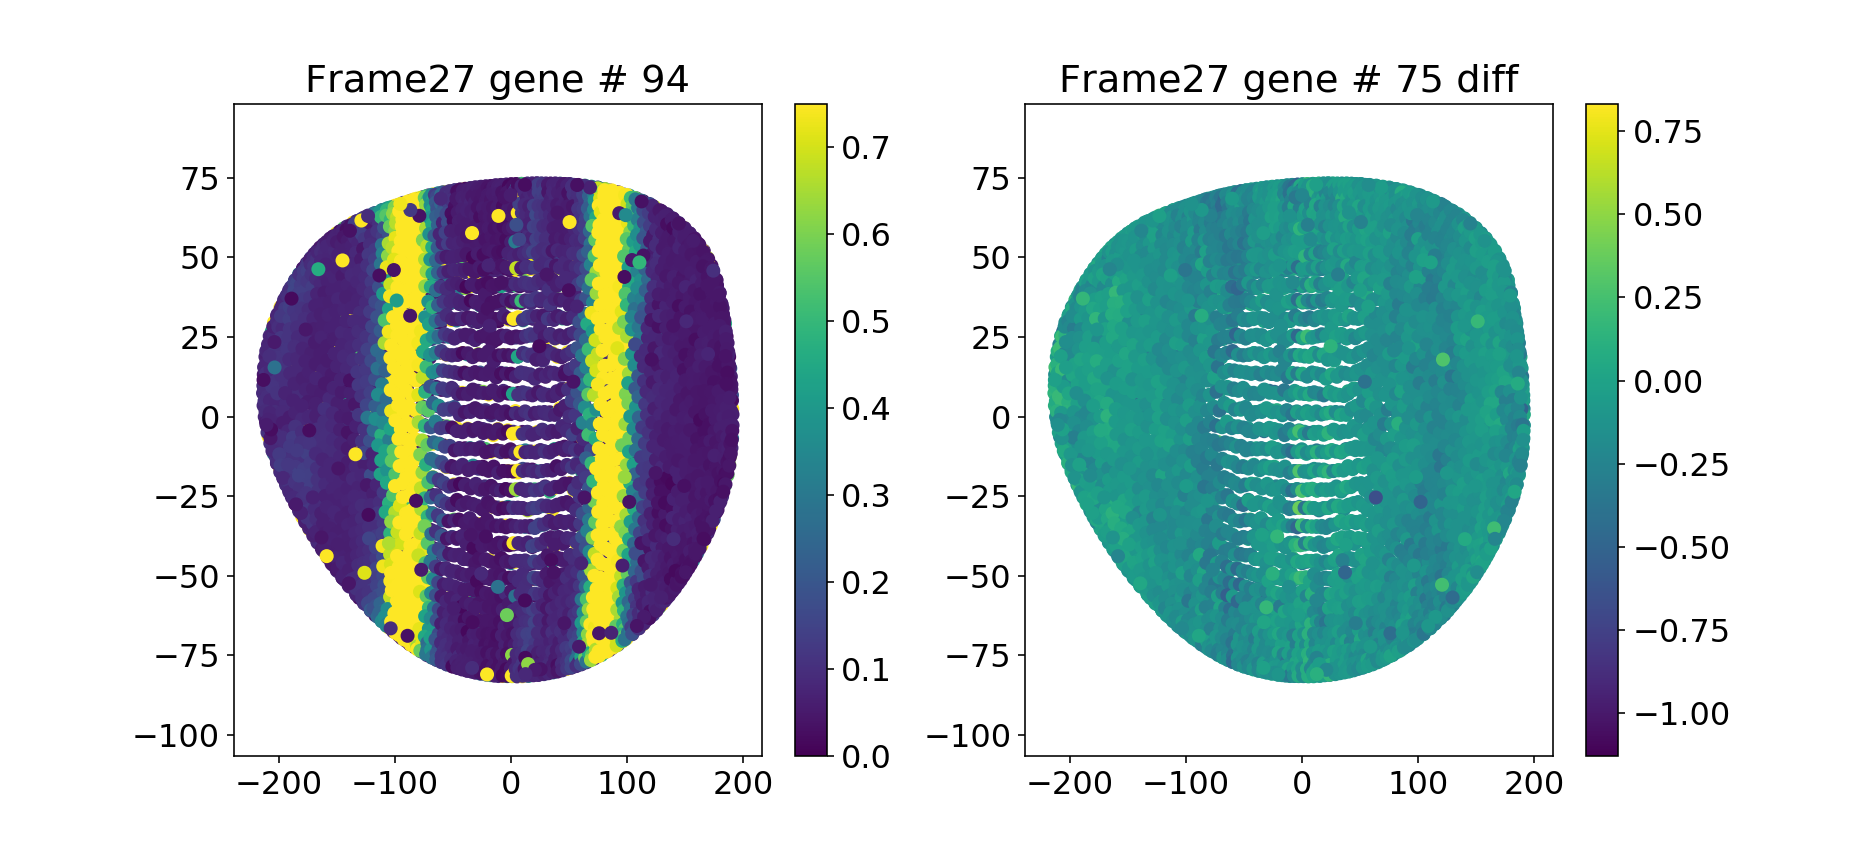

In [16]:
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
ax1.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
scat1 = ax1.scatter(xyz[:,0], xyz[:,2], c=stacks[:,95,0])
plt.colorbar(scat1, ax=ax1)

ax2.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
scat2 = ax2.scatter(xyz[:,0], xyz[:,2], c=diff[:,76,0])
plt.colorbar(scat2, ax=ax2)

def animate(i):
    color1 = stacks[:,95,i]
    scat1.set_array(color1)
    color2 = diff[:,76,i]
    scat2.set_array(color2)
    ax1.set_title('Frame' + str(i) + ' gene # 94')
    ax2.set_title('Frame' + str(i) + ' gene # 75 diff')

mywriter = matplotlib.animation.FFMpegWriter()
anim = FuncAnimation(fig, animate, interval=15, frames=51)
plt.draw()
plt.show()

# anim.save("test.png", writer=mywriter)
# plt.savefig('test.pdf')

In [14]:
# %matplotlib inline
# %matplotlib inline

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
# ax1.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
# scat1 = ax1.scatter(xyz[:,0], xyz[:,2], c=stacks[:,95,0])
# plt.colorbar(scat1, ax=ax1)
# ax1.set_title('Frame 0, gene #94')

# ax2.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
# scat2 = ax2.scatter(xyz[:,0], xyz[:,2], c=diff[:,76,0])
# plt.colorbar(scat2, ax=ax2)
# ax2.set_title('Frame 0, gene #75 diff')

# plt.savefig('frame_0')
# plt.close()

# for i in range(1,51):
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
#     ax1.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
#     ax1.scatter(xyz[:,0], xyz[:,2], c=stacks[:,95,i])
#     plt.colorbar(scat1, ax=ax1)
#     ax1.set_title('Frame %s, gene #94' %i)

#     ax2.set(xlim=(np.min(xyz[:,0])-25, np.max(xyz[:,0]+25)), ylim=(np.min(xyz[:,2]-25), np.max(xyz[:,2]+25)))
#     ax2.scatter(xyz[:,0], xyz[:,2], c=diff[:,76,i])
#     plt.colorbar(scat2, ax=ax2)
#     ax2.set_title('Frame %s, gene #75 diff' %i)
    
#     plt.savefig('frame_'+str(i))
#     plt.close()

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
